# Trabalho Final: Identificação e Rastreamento de Trilhas em PCB

**Alunos:** Gabriel Batista Barbosa // Luan Almeida Valença
**Disciplina:** Processamento de Imagens

## Resumo
Este notebook apresenta uma solução robusta para a engenharia reversa de conexões em Placas de Circuito Impresso (PCB).
A abordagem utiliza um pipeline paralelo:
1.  **Pré-processamento:** Binarização adaptativa (Sauvola) para separar trilhas finas sem curto-circuito.
2.  **Detecção de Pads (Via Espessura):** Uso da Transformada de Distância para identificar ilhas de solda baseando-se na sua espessura, ignorando a geometria.
3.  **Mapeamento de Trilhas:** Esqueletização global da malha de cobre.
4.  **Netlist:** Cruzamento espacial entre coordenadas dos Pads e Rótulos do Esqueleto para gerar a lista de conexões (X <-> Y).

## Bibliotecas Utilizadas
* **NumPy:** Manipulação matricial.
* **Matplotlib:** Visualização de dados e mapas de calor.
* **Scikit-Image:** Algoritmos de morfologia e esqueletização.
* **SciPy (ndimage):** Transformada de Distância Euclidiana e preenchimento de buracos.

In [86]:
import numpy as np
import matplotlib.pyplot as plt
import os
from skimage import io, color, filters, morphology, measure
from scipy.ndimage import distance_transform_edt, binary_fill_holes

# Configuração para exibir imagens lado a lado
def show_steps(images, titles, cmap='gray'):
    n = len(images)
    fig, axes = plt.subplots(1, n, figsize=(6 * n, 6))
    if n == 1: axes = [axes]
    
    for ax, img, title in zip(axes, images, titles):
        if title == "Transformada de Distância": # Mapa de calor especial
            im = ax.imshow(img, cmap='jet')
            plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
        else:
            ax.imshow(img, cmap=cmap)
        ax.set_title(title)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

print("Bibliotecas carregadas com sucesso.")

Bibliotecas carregadas com sucesso.


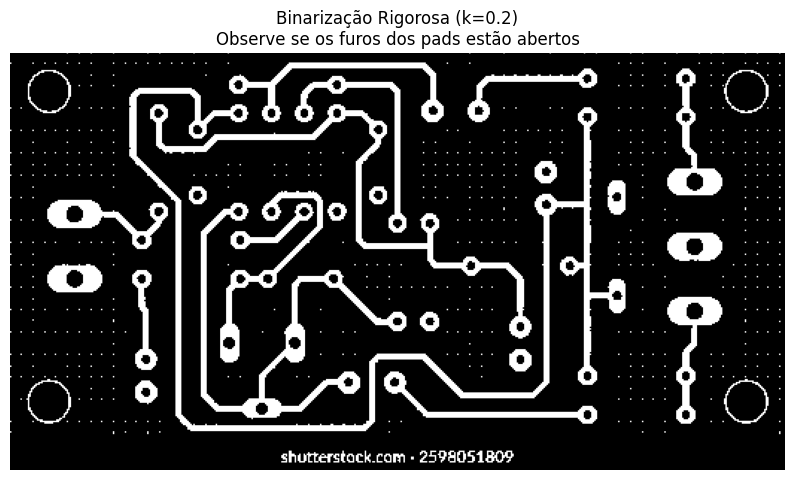

In [87]:
PASTA_IMAGENS = 'Imagens'
NOME_ARQUIVO = 'img8.webp'  # Nome da sua imagem atual
caminho_completo = os.path.join(PASTA_IMAGENS, NOME_ARQUIVO)

# 1. Carregamento
try:
    img_original = io.imread(caminho_completo)
except FileNotFoundError:
    print(f"ERRO: Imagem não encontrada.")
    img_original = np.zeros((200, 200), dtype=np.uint8)

# 2. Conversão para Cinza
if img_original.ndim == 3:
    if img_original.shape[2] == 4:
        img_rgb = color.rgba2rgb(img_original)
        img_gray = color.rgb2gray(img_rgb)
    else:
        img_gray = color.rgb2gray(img_original)
else:
    img_gray = img_original

# 3. Binarização Sauvola (AJUSTE DE SENSIBILIDADE AQUI!)
window_size = 25

# --- O GRANDE TRUQUE ---
# k = 0.05 -> Trilhas grossas, furos fecham (O que estavamos usando)
# k = 0.2  -> Trilhas médias, furos abrem (Ideal)
# k = 0.5  -> Trilhas quebram, furos gigantes
k_factor = 0.2  # Aumentei para forçar a abertura dos furos!

thresh_sauvola = filters.threshold_sauvola(img_gray, window_size=window_size, k=k_factor)
img_binary = img_gray > thresh_sauvola

# 4. Ajustar Polaridade (Fundo=Preto)
if np.sum(img_binary) > (img_binary.size / 2):
    img_binary = ~img_binary

# Debug Visual: Vamos ver se o furo apareceu?
plt.figure(figsize=(10, 10))
plt.imshow(img_binary, cmap='gray')
plt.title(f"Binarização Rigorosa (k={k_factor})\nObserve se os furos dos pads estão abertos")
plt.axis('off')
plt.show()

--- DIAGNÓSTICO DE TAMANHO ---
Áreas encontradas (pixels): [np.float64(1.0), np.float64(1.0), np.float64(2.0), np.float64(4.0), np.float64(4.0), np.float64(4.0), np.float64(6.0), np.float64(6.0), np.float64(6.0), np.float64(9.0), np.float64(9.0), np.float64(14.0), np.float64(14.0), np.float64(24.0), np.float64(25.0), np.float64(26.0), np.float64(26.0), np.float64(26.0), np.float64(26.0), np.float64(26.0), np.float64(26.0), np.float64(26.0), np.float64(26.0), np.float64(26.0), np.float64(26.0), np.float64(26.0), np.float64(26.0), np.float64(27.0), np.float64(27.0), np.float64(27.0), np.float64(27.0), np.float64(27.0), np.float64(27.0), np.float64(27.0), np.float64(27.0), np.float64(27.0), np.float64(27.0), np.float64(28.0), np.float64(28.0), np.float64(28.0), np.float64(28.0), np.float64(28.0), np.float64(28.0), np.float64(28.0), np.float64(28.0), np.float64(28.0), np.float64(28.0), np.float64(29.0), np.float64(29.0), np.float64(29.0), np.float64(29.0), np.float64(29.0), np.float64(29.0

C:\Users\Luan\AppData\Local\Temp\ipykernel_1724\812520468.py:26: FutureWarning: Parameter `min_size` is deprecated since version 0.26.0 and will be removed in 2.0.0 (or later). To avoid this warning, please use the parameter `max_size` instead. For more details, see the documentation of `remove_small_objects`. Note that the new threshold removes objects smaller than **or equal to** its value, while the previous parameter only removed smaller ones.
  img_holes_clean = morphology.remove_small_objects(img_holes_raw, min_size=3)


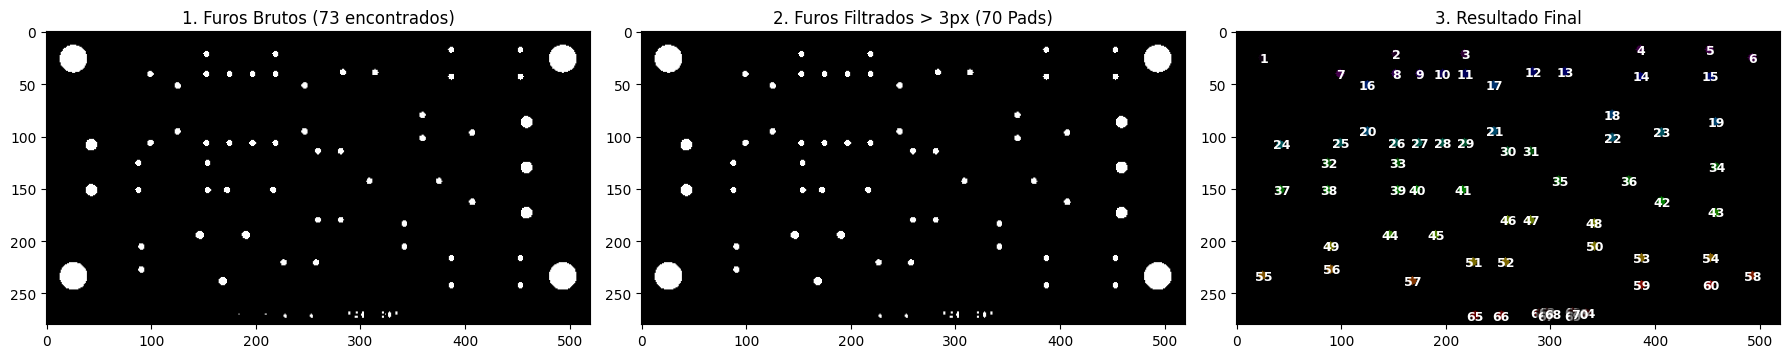

In [88]:
# Célula 4: Detecção Hole-First (Versão Diagnóstica)

# 1. SEGURANÇA: Limpar bordas
img_safe = img_binary.copy()
margem = 5
img_safe[:margem, :] = 0
img_safe[-margem:, :] = 0
img_safe[:, :margem] = 0
img_safe[:, -margem:] = 0

# 2. Gerar o Mapa de Furos (O Gabarito)
img_solid = binary_fill_holes(img_safe)
img_holes_raw = img_solid & ~img_safe

# 3. DIAGNÓSTICO DE ÁREA (O Pulo do Gato)
# Vamos ver qual o tamanho real desses 21 furos que você vê.
label_raw = measure.label(img_holes_raw)
props_raw = measure.regionprops(label_raw)

areas = sorted([p.area for p in props_raw])
print(f"--- DIAGNÓSTICO DE TAMANHO ---")
print(f"Áreas encontradas (pixels): {areas}")

# Definimos o filtro baseado no que vimos (segurança contra ruído de 1px)
# Se o menor pad tiver 5px, cortamos em 3.
img_holes_clean = morphology.remove_small_objects(img_holes_raw, min_size=3)

# 4. Rotulagem Final
label_holes = measure.label(img_holes_clean)
props_holes = measure.regionprops(label_holes)

pads_metadata = []

for prop in props_holes:
    y, x = prop.centroid
    pads_metadata.append({'y': y, 'x': x})

print(f"\n>> Pads Detectados: {len(pads_metadata)} (Meta: 21)")

# 5. Ordenação
pads_metadata.sort(key=lambda k: (int(k['y'] // 15), k['x']))

# 6. Visualização
pads_display_map = np.zeros_like(img_binary, dtype=int)
final_pads_list = []

for i, data in enumerate(pads_metadata):
    yc, xc = int(data['y']), int(data['x'])
    rr_idx, cc_idx = morphology.disk(4).nonzero()
    rr_idx = rr_idx - 4 + yc
    cc_idx = cc_idx - 4 + xc
    valid = (rr_idx >= 0) & (rr_idx < img_binary.shape[0]) & \
            (cc_idx >= 0) & (cc_idx < img_binary.shape[1])
    pads_display_map[rr_idx[valid], cc_idx[valid]] = i + 1
    data['id'] = i + 1
    final_pads_list.append(data)

# PLOT
fig, ax = plt.subplots(1, 3, figsize=(18, 6))

ax[0].imshow(img_holes_raw, cmap='gray')
ax[0].set_title(f'1. Furos Brutos ({len(props_raw)} encontrados)')

ax[1].imshow(img_holes_clean, cmap='gray')
ax[1].set_title(f'2. Furos Filtrados > 3px ({len(props_holes)} Pads)')

ax[2].imshow(pads_display_map, cmap='nipy_spectral')
ax[2].set_title(f'3. Resultado Final')

for p in final_pads_list:
    ax[2].text(p['x'], p['y'], str(p['id']), 
               color='white', fontsize=9, fontweight='bold', 
               ha='center', va='center', 
               bbox=dict(facecolor='black', alpha=0.5, edgecolor='none', boxstyle='round,pad=0.1'))

plt.tight_layout()
plt.show()

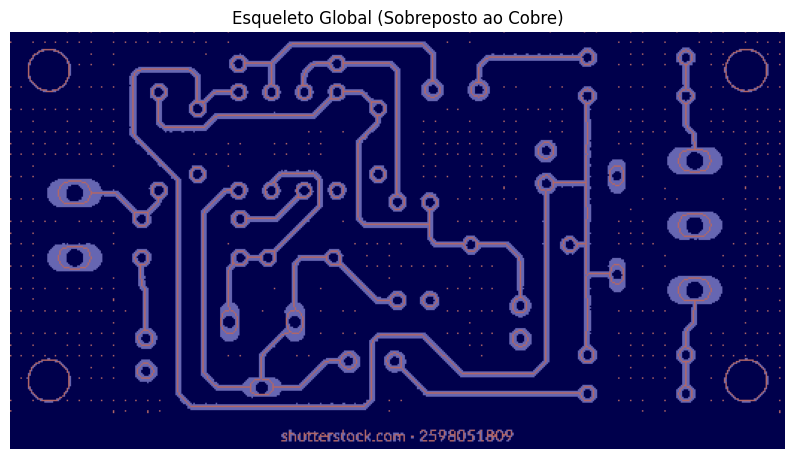

In [89]:
# 1. Esqueletização
# Usamos a imagem binária original (com furos), pois o esqueleto deve seguir o cobre real.
skeleton = morphology.skeletonize(img_binary)

# 2. Rotulagem de Redes
# Conectividade=2 permite que pixels diagonais façam parte da mesma trilha.
skeleton_labeled = measure.label(skeleton, connectivity=2)

# Visualização de Debug
plt.figure(figsize=(10, 10))
plt.imshow(img_binary, cmap='gray')
plt.imshow(skeleton, cmap='jet', alpha=0.6)
plt.title("Esqueleto Global (Sobreposto ao Cobre)")
plt.axis('off')
plt.show()

In [90]:
# Lógica de Conectividade: Cruzamento Espacial
connections = {}

# Para cada Pad encontrado na Célula 4...
for pad in final_pads_list:
    pad_id = pad['id']
    yc, xc = int(pad['y']), int(pad['x'])
    
    # ...verificamos qual trilha (esqueleto da Célula 5) passa perto dele.
    # Usamos uma janela de tolerância de 5 pixels.
    WIN = 5
    y_min, y_max = max(0, yc - WIN), min(img_binary.shape[0], yc + WIN)
    x_min, x_max = max(0, xc - WIN), min(img_binary.shape[1], xc + WIN)
    
    # Recorte do esqueleto rotulado
    skel_crop = skeleton_labeled[y_min:y_max, x_min:x_max]
    
    # Quais IDs de esqueleto existem aqui? (Excluindo 0=Fundo)
    fios_encontrados = np.unique(skel_crop)
    fios_encontrados = fios_encontrados[fios_encontrados > 0]
    
    # Registra que a Trilha X toca no Pad Y
    for fio in fios_encontrados:
        if fio not in connections:
            connections[fio] = set()
        connections[fio].add(pad_id)

# Gerar Netlist (Formatada X <-> Y)
netlist = []
for fio_id, pads_connected in connections.items():
    # Se uma trilha toca 2 ou mais pads, existe condução elétrica.
    if len(pads_connected) >= 2:
        pads_sorted = sorted(list(pads_connected))
        
        # Gera todas as combinações de pares conectados por esse fio
        import itertools
        for a, b in itertools.combinations(pads_sorted, 2):
            netlist.append(f"{a} <-> {b}")

# Remove duplicatas e ordena
netlist = sorted(list(set(netlist)))

print("\n" + "="*40)
print(f"NETLIST FINAL ({len(netlist)} Conexões)")
print("="*40)

if not netlist:
    print("AVISO: Nenhuma conexão detectada.") 
    print("Dica: Verifique se o esqueleto está tocando os centros dos pads na imagem acima.")
else:
    for con in netlist:
        print(con)


NETLIST FINAL (81 Conexões)
10 <-> 30
11 <-> 17
11 <-> 31
11 <-> 35
11 <-> 48
14 <-> 16
14 <-> 22
14 <-> 36
14 <-> 42
14 <-> 53
16 <-> 22
16 <-> 36
16 <-> 42
16 <-> 53
17 <-> 31
17 <-> 35
17 <-> 48
2 <-> 12
2 <-> 9
22 <-> 36
22 <-> 42
22 <-> 53
25 <-> 32
26 <-> 41
26 <-> 45
26 <-> 46
26 <-> 51
26 <-> 57
27 <-> 39
27 <-> 40
27 <-> 44
28 <-> 33
3 <-> 10
3 <-> 30
31 <-> 35
31 <-> 48
35 <-> 48
36 <-> 42
36 <-> 53
38 <-> 49
39 <-> 40
39 <-> 44
4 <-> 13
40 <-> 44
41 <-> 45
41 <-> 46
41 <-> 51
41 <-> 57
42 <-> 53
45 <-> 46
45 <-> 51
45 <-> 57
46 <-> 51
46 <-> 57
5 <-> 15
51 <-> 57
52 <-> 59
54 <-> 60
61 <-> 62
61 <-> 67
62 <-> 67
62 <-> 68
63 <-> 64
63 <-> 69
63 <-> 70
64 <-> 69
64 <-> 70
67 <-> 68
69 <-> 70
7 <-> 11
7 <-> 17
7 <-> 31
7 <-> 35
7 <-> 48
8 <-> 14
8 <-> 16
8 <-> 22
8 <-> 36
8 <-> 42
8 <-> 53
9 <-> 12
